Reliability Models for Facility Location:The Expected Failure Cost Case
---

Base on the following article:

*Snyder, L. V., & Daskin, M. S. (2005). Reliability models for facility location: the expected failure cost case. Transportation Science, 39(3), 400-416.*

In [1]:
# Colecting the problem
from PythonLib.dataset.mongodb import MongoClient
# Solving the problem
from PythonLib.solvers.uflp import uflp
# Representing the network
from PythonLib.dataviz.network import Network

from sklearn.neighbors import DistanceMetric
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2

## Selecting the problem

First, we collect the dataset from our database using **MonClient**.

In [65]:
dataset = MongoClient(db = {
# MongoClient let us connect to the database and manipulate our dataset
    "mongo_host": "ns396089.ip-37-59-38.eu",
    "mongo_port": 32771,
    "mongo_db_name": "NETWORK-AND-DISCRETE-LOCATION"
}, q = {
    'metadata.author': 'Mark S. Daskin',
    'metadata.topic': 'NETWORK-AND-DISCRETE-LOCATION',
    'metadata.dataset': '49-nodes'
},f=None)

We can display the dataset using the method **get** which return a pandas Dataframe containing our data

In [66]:
df = dataset.get()
df.head()

,ID,LATITUDE,LONGITUDE,STATE POP,CITY POP,FIXED COST,CITY
0,1,-121.467360,38.566850,29760021,369365,115800,< Sacramento CA >
1,2,-73.799017,42.665750,17990455,101082,101800,< Albany NY >
2,11,-84.422592,33.762900,6478216,394017,71200,< Atlanta GA >
3,12,-77.474584,37.531050,6187358,203056,66600,< Richmond VA >
4,13,-71.017892,42.336029,6016425,574283,161400,< Boston MA >


## Solving the UFLP problem

The uncapacitated facility location problem takes as inputs two sets of **Customers** and **Facilities**, as well as the list **f** containing the fixed cost of each facility and the matrix **c** representing the cost of serving a customer given a facility.

In [156]:
# Set of customer
Customers = df.index.tolist()
Facilities = df.index.tolist()
fixed_cost = df["FIXED COST"]
# Distance matrix in Km frm long/lat
distances = DistanceMetric.get_metric('haversine').pairwise(df[["LATITUDE","LONGITUDE"]].apply(np.radians)) * 3959
# The transportation cost are taken to be $0.00001 per mile per unit of demande
# The demande is proportinal to the state population
transportation_cost = 0.00001 * distances * df["STATE POP"][None, :]

In [177]:
transportation_cost[2][0]

761419.82202686067

In [172]:
m, X, Y = uflp(Customers, Facilities, fixed_cost, transportation_cost, name='UFLP')

In [158]:
from docplex.mp.environment import Environment
env = Environment()
env.print_information()

* system is: Linux 64bit
* Python is present, version is 3.6.5
* docplex is present, version is (2, 4, 61)
* CPLEX wrapper is present, version is 12.8.0.0, located at: /opt/conda/lib/python3.6/site-packages


In [159]:
m.print_information()

Model: UFLP
 - number of variables: 2450
   - binary=2450, integer=0, continuous=0
 - number of constraints: 2450
   - linear=2450
 - parameters: defaults


In [160]:
solution = m.solve()

In [161]:
solution.solve_details.time

0.2055668830871582

In [162]:
m.export_as_lp("uflp_formulation")

'uflp_formulation.lp'

In [163]:
solution.export("uflp_solution.json")

In [164]:
solution.kpi_value_by_name("transportation cost")

136291.72306687225

In [165]:
solution.kpi_value_by_name("fixed cost")

157400

## Analyse the probleme and the solution

We use the **dataviz** package to convert our dataset into a **Network** object so that we can plot it.

In [166]:
network = Network(dataset)

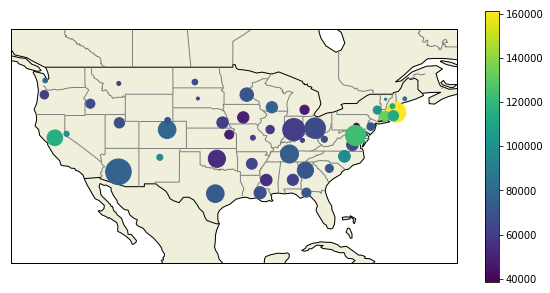

In [167]:
network.plot_nodes(node_size=("CITY POP",1/1500), node_color="FIXED COST")

In [168]:
network.G.add_edges_from([key for key in X if X[key].solution_value == 1])

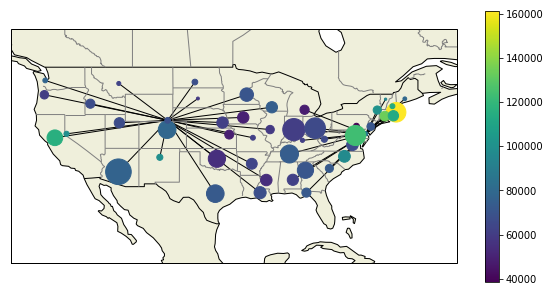

In [169]:
network.plot_nodes(node_size=("CITY POP",1/1500), node_color="FIXED COST")

In [170]:
network.G.edges

EdgeView([(0, 43), (1, 39), (2, 39), (3, 39), (4, 39), (5, 39), (6, 43), (7, 43), (8, 39), (9, 43), (10, 39), (11, 43), (12, 43), (13, 43), (14, 39), (15, 39), (16, 43), (17, 39), (18, 43), (19, 39), (20, 43), (21, 43), (22, 43), (23, 39), (24, 43), (25, 43), (26, 43), (27, 39), (28, 43), (29, 43), (30, 43), (31, 39), (32, 43), (33, 39), (34, 39), (35, 43), (36, 39), (37, 43), (38, 43), (39, 39), (39, 41), (39, 42), (39, 45), (39, 46), (39, 47), (39, 48), (40, 43), (43, 43), (43, 44)])

In [171]:
[key for key in Y if Y[key].solution_value == 1]

[39, 43]